Download database if database does not exist.

In [16]:
![ ! -d "physionet.org" ] && wget -r -N -c -np -q https://physionet.org/files/slpdb/1.0.0/

In [17]:
%%bash
which bash

/usr/bin/bash


Download libraries.

In [32]:
import sys
!{sys.executable} -m pip install -q wfdb tinymlgen --user
!{sys.executable} -m pip install matplotlib==3.1.3 --user

'C:\Users\Ho' is not recognized as an internal or external command,
operable program or batch file.
'C:\Users\Ho' is not recognized as an internal or external command,
operable program or batch file.


Import libraries and set random seed.

In [46]:
# For reading database
import wfdb
import os
import copy
import numpy as np
import scipy as sp
from scipy import signal
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras import utils
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

## **1. Import Database**
Accessing data and basic data processing.


In [34]:
class PatientData (object):
    ECG_signal = None
    EEG_signal = None
    sleep_stages = None

    record_length = None
    sampling_frequency = None

    def __init__ (self, patient_name):
        self.patient_name = patient_name

In [35]:
DATABASE_PATH = 'physionet.org/files/slpdb/1.0.0'

with open(os.path.join(DATABASE_PATH, 'RECORDS'), 'r') as file:
    PATIENT_NAMES = file.read().split('\n')[:-1]
  
PATIENTS = {
    patient_name: PatientData(patient_name)
    for patient_name in PATIENT_NAMES
}

In [405]:
# 0 Awake
# 1 NREM stage 1
# 2 NREM stage 2
# 3 NREM stage 3 and 4
# 4 REM
def annotation_sleep_stage (annotation):
    if annotation.startswith('W'):
        return 0
    elif annotation.startswith('1'):
        return 1
    elif annotation.startswith('2'):
        return 2
    elif annotation.startswith('3') or annotation.startswith('4'):
        return 3
    elif annotation.startswith('R'):
        return 4
    # Ideally, all annotations are classified into one of the above 5
    else:
        return -1

# Since annotations only have labels and the time at which they occur,
# interpolate all the data so there's always a label at each time step
def step_interpolation (data, locations, total_length):
    step_interpolated_data = np.zeros(total_length)

    for i in range(len(locations) - 1):
        start_range = locations[i]
        end_range = locations[i + 1]

        # Convert string annotation into sleep stage
        step_interpolated_data[(start_range - 1) : end_range] = annotation_sleep_stage(data[i])

    return step_interpolated_data

In [406]:
for patient_name in PATIENT_NAMES:
    patient = PATIENTS[patient_name]

    # Retrieve raw signals and annotations
    record_path = os.path.join(DATABASE_PATH, patient_name)
    record = wfdb.io.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, extension='st')

    # Sampling frequency
    # This might differ for each record
    patient.sampling_frequency = record.fs

    # 0 ECG
    # 1 BP
    # 2 EEG
    # 3 Resp (not available for all)
    patient.ECG_signal = record.p_signal[:, 0]
    patient.EEG_signal = record.p_signal[:, 2]
    patient.record_length = record.sig_len

    patient.sleep_stages = step_interpolation(annotation.aux_note, annotation.sample, patient.record_length)

In [549]:
# Example patient
patient_slp01a = PATIENTS['slp01a']
print(patient_slp01a.ECG_signal)
print(patient_slp01a.EEG_signal)
print(patient_slp01a.sleep_stages)

[0.085 0.08  0.125 ... 0.23  0.235 0.225]
[-0.03919129 -0.03888025 -0.03856921 ...  0.14727838  0.14681182
  0.14261275]
[3. 3. 3. ... 0. 0. 0.]


In [408]:
# Splitting the dataset into train, validation, test set
# Will be split in terms of patients, not sleep data
num_patients = len(PATIENTS)

# Shuffle patients
randomized_patients = copy.deepcopy(list(PATIENTS.keys()))
np.random.shuffle(randomized_patients)

# 80 / 10 / 10 split of 18 patients will be roughly 14 / 2 / 2
# Don't need test_end, since it'll be until the end of data
train_end = 14
valid_end = train_end + 2

# Split data using keys
train_patients = randomized_patients[ : train_end]
valid_patients = randomized_patients[train_end : valid_end]
test_patients = randomized_patients[valid_end : ]

## **2. Building the Neural Network**

In [534]:
def create_dataset(patient_set, window_size=30, diagnostic=False):
    inputs = []
    labels = []
    
    i = 0
    for patient_name in patient_set:
        patient = PATIENTS[patient_name]
        total_samples = patient.EEG_signal.shape[0]

        # Represents the number of samples (individual numbers) in one window of time (measured in seconds)
        samples_per_window = int(window_size * patient.sampling_frequency)
        
        # Represents how many data points is generated after division with windows
        # If the window size is larger, there will be less data points (but more samples per data point)
        windows = np.round(total_samples / samples_per_window).astype(np.int64)
        
        
        
        if diagnostic:
            print("Gathering {} patient data...".format(patient_name))
            print("> Total number of samples = {}".format(total_samples))
            print("  Samples per window size of {} seconds = {}".format(window_size, samples_per_window))
            print("  Number of windows = {}".format(windows))
            print("  Number of batches for batch size {} = {}".format(batch_size, batches))

            
            
        for datum in range(windows):
            '''
            current_batch_inputs = []
            current_batch_labels = []
            
            for datum in range(batch_size):
            '''
            # Determine start and end of current batch
            # Function assumes that batch sizes match the number of samples perfectly
            start = (datum * samples_per_window)
            end = (start + samples_per_window)

            '''
            EEG_MFCC = librosa.feature.melspectrogram(
                y=patient.EEG_signal[start : end], 
                sr=patient.sampling_frequency)
            ECG_MFCC = librosa.feature.melspectrogram(
                y=patient.ECG_signal[start : end], 
                sr=patient.sampling_frequency)

            sample = np.expand_dims(
                np.stack([ EEG_MFCC, ECG_MFCC ], axis=2), 
                axis=0)
            '''
            
            # ORIGINAL 
            #EEG = patient.EEG_signal[start : end]
            #ECG = patient.ECG_signal[start : end]
            
            # using wave frequencies
            sf = 250
            freqs, psd = sp.signal.welch(patient.EEG_signal[start : end], sf, nperseg=(4 * sf))
            delta = psd[np.logical_and(freqs >= 0.25, freqs < 4)]
            theta = psd[np.logical_and(freqs >= 4, freqs < 8)]
            alpha = psd[np.logical_and(freqs >= 8, freqs < 12)]
            sigma = psd[np.logical_and(freqs >= 12, freqs < 16)]
            beta = psd[freqs >= 16] # for awake stage only 
            EEG = np.concatenate((delta, theta, alpha, sigma, beta)).tolist()
            ECG = patient.ECG_signal[start : end]
            '''
            sample = [
                patient.EEG_signal[start : end],
                patient.ECG_signal[start : end]
            ]
            '''
            sample = patient.EEG_signal[start : end]
            # Only grab the label at the end of the current batch
            # This is such that we're using all of the data in the current batch
            # in order to predict the sleep stage by the end of the batch
            sample_labels = patient.sleep_stages[end - 1]
            '''
                current_batch_inputs.append(sample)
                current_batch_labels.append(sample_labels)
            '''
            inputs.append(sample)
            labels.append(sample_labels)
            
        i += 1
        if i == 1:
            break

    return np.expand_dims(np.array(inputs), axis=-1), np.expand_dims(np.array(labels), axis=-1)

In [535]:
# Create training and validation dataset
train_data, train_labels = create_dataset(train_patients, diagnostic=False)
valid_data, valid_labels = create_dataset(valid_patients, diagnostic=False)

In [536]:
print(train_data.shape)
print(train_labels.shape)

(480, 7500, 1)
(480, 1)


In [516]:
# Inception layer
# Two 1D convolution layers in parallel concatenate at the end
# Left and right filter amounts can be modified
class Inception1D (layers.Layer):

    def __init__ (self, left_filter, right_filter):
        super(Inception1D, self).__init__()

        # Left-side convolution
        self.left_conv = layers.Conv1D(
            filters=left_filter, 
            kernel_size=1,
            padding='same',
            activation='relu')

        # Right-side convolution
        self.right_conv = layers.Conv1D(
            filters=right_filter, 
            kernel_size=3,
            padding='same',
            activation='relu')

    def call (self, inputs, training=False):
        left = self.left_conv(inputs)
        right = self.right_conv(inputs)
        x = layers.Concatenate()([left, right])
        x = layers.MaxPooling1D()(x)
        if training:
            x = layers.SpatialDropout1D(0.01)(x)

        return x

In [547]:
class PCNN (tf.keras.Model):
    
    def __init__ (self):
        super(PCNN, self).__init__()
        
        self.EEG = [
            Inception1D(64, 64),
            Inception1D(16, 16),
            Inception1D(8, 8),
            Inception1D(8, 8),
            Inception1D(8, 8)
        ]
        
        self.ANN = [
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(5, activation='softmax')
        ]
    
    def call (self, inputs, training=False):
        #eeg = inputs[:,0]
        #ecg = inputs[:,1]
        
        eeg = inputs
        
        # Parallel convolutional networks
        for conv in self.EEG:
            eeg = conv(eeg)
            #ecg = conv(ecg)
            
        # Self-attention
        #eeg_attention = layers.Attention()([eeg, eeg])
        #ecg_attention = layers.Attention()([ecg, ecg])
            
        # Concatenate convolutional embedding
        # Perform dropouts and batch normalization for ANN classifier
        #eeg = layers.Concatenate()([eeg, eeg_attention])
        #ecg = layers.Concatenate()([ecg, ecg_attention])
        x = layers.Concatenate()([eeg])
        x = layers.Flatten()(x)
        
        # Only include dropouts during trainning
        if training:
            x = layers.Dropout(0.05)(x)
        
        # Fully-connected classifier
        for layer in self.ANN:
            x = layer(x)
            
        return x
        


model = PCNN()

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(0.001),
    loss      = tf.keras.losses.CategoricalCrossentropy(),
    metrics   = tf.keras.metrics.CategoricalAccuracy()
)

In [548]:
# Train the neural network
history = model.fit(
    x               = train_data,
    y               = utils.to_categorical(train_labels),
    epochs          = 5,
    validation_data = (
        valid_data,
        utils.to_categorical(valid_labels)
    )
)

Epoch 1/5
15/15 [==============================] - 10s 609ms/step - loss: 1.5677 - categorical_accuracy: 0.3146 - val_loss: 1.5849 - val_categorical_accuracy: 0.2936
Epoch 2/5
15/15 [==============================] - 8s 567ms/step - loss: 1.5204 - categorical_accuracy: 0.3375 - val_loss: 1.5481 - val_categorical_accuracy: 0.2936
Epoch 3/5
15/15 [==============================] - 9s 582ms/step - loss: 1.5000 - categorical_accuracy: 0.3375 - val_loss: 1.5678 - val_categorical_accuracy: 0.2936
Epoch 4/5
15/15 [==============================] - 9s 584ms/step - loss: 1.4959 - categorical_accuracy: 0.3375 - val_loss: 1.5143 - val_categorical_accuracy: 0.2936
Epoch 5/5
15/15 [==============================] - 9s 585ms/step - loss: 1.4242 - categorical_accuracy: 0.3375 - val_loss: 1.4873 - val_categorical_accuracy: 0.2936


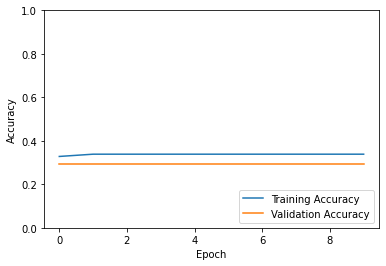

In [496]:
# Graph training accuracy
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

In [443]:
# Get test accuracy of the network
test_data, test_labels = create_dataset(valid_patients, diagnostic=False)
model.evaluate(test_data, utils.to_categorical(test_labels))

97/97 [==============================] - 3s 29ms/step - loss: 2.2326 - categorical_accuracy: 0.3490


[2.23262357711792, 0.3490259647369385]